# Прогнозирование вероятности оттока пользователей для фитнес-центров.

## Описание проекта
На основе данных о посетителях сети фитнес-центров спрогнозировать вероятность оттока 
для каждого клиента в следующем месяце, сформировать с помощью кластеризации портреты пользователей.

1. [Загрузка данных.](#Шаг-1.-Загрузка-данных.)
2. [Исследовательский анализ данных.](#Шаг-2.-Исследовательский-анализ-данных.)
3. [Модель прогнозирования оттока клиентов.](#Шаг-3.-Модель-прогнозирования-оттока-клиентов.)
4. [Кластеризация клиентов.](#Шаг-4.-Кластеризация-клиентов.)
5. [Выводы и рекомендации](#Шаг-5.-Выводы-и-рекомендации.)

### Шаг 1. Загрузка данных.

Импортирование модулей, необходимых для работы

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth
from plotly import graph_objects as go


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

import warnings
warnings.filterwarnings('ignore')  

Чтение данных и визуалиция таблицы 

In [2]:
data = pd.read_csv('данные предоставлены Яндекс.Практикум')
data

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


#### Вывод 
В начальной таблице  14 колонок: 

- `Churn` — факт оттока в текущем месяце;
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба;
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»;
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Проведем обработку данных - заменим названия колонок на единый регистр, изучим тип данных, посмотрим на наличие пропущенных значений и дубликатов.

### Шаг 2. Исследовательский анализ данных.

Используем для более подробного изучения данных универсальную функцию

In [3]:
def df_view(df):
    """
    Быстрый обзор таблицы
    """
    df.rename(str.lower, axis='columns', inplace=True)
    print(df.columns)
    display(df)
    a = df.duplicated().sum()
    print(df.info())
    print()
    print('Количество дубликатов в таблице', a)

In [4]:
df_view(data)

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')


,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
None

Количество дубликатов в табл

Данные готовы для дальнейшего анализа: 4000 значений в 14 столбцах. Поменяли названия столбцов, используя единый нижний регистр, типы данных колонок `float64` и `int64` соответствуют ожидаемым и не требуют изменений. пропущенных значений и дубликатов не обнаружено.

Изучим средние значения данных и стандартные отклонения, используя метод `describe()`

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из полученных данных видно, что в среднем:

раcпределение по полу примерно равное; 84,5% пользователей проживает и работает в районе фитнес-центра; 48,7% пользователей являются сотрудниками компаний-партнеров клуба; 30% пришли по программе клуба "Приведи друга"; 90% оставили контактный номер телефона; 4,7 мес - средняя длительность текущего абонемента; 41% пользователей посещают групповые занятия; 29 лет - средний возраст пользователя; 147 - средняя суммарная выручка от дополнительных услуг центра на клиента; 4,3 мес - средний срок до окончания действующего абонемента; 3,7 мес - время с момента первого обращения в фитнес-центр; 1,88 раз - средняя частота посещений в неделю за все время с начала дйствия абонемента; 1,77 раз - средняя частота посещений в неделю по данным за предыдущий месяц; 26,5% - отток пользователей в текущем месяце.







Посмотрим на средние значения признаков для 2 групп пользователей (1 - ушли в отток, 0 - остались клиентами фитнес-центра).

In [6]:
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По изменению средних показателей основных признаков для этих двух групп можно сделать следующие выводы - те, кто живут ближе реже попадает в отток; сотрудники компаний-партнеров реже перестают посещать фитнес-центр, чем другие клиенты; клиенты, пришедшие по акции "Приведи друга" уходят в отток в 2 раза реже; средняя длительность абонемента в оттоке 1,72 месяца - говорит о том, что эти люди чаще берут абонемент на 1-3 месяца; клиенты в группе оттока почти в 2 раза реже посещают групповые занятия, чуть младше в среднем по возрасту, тратят меньше денег на дополнительные услуги центра, время до окончания срока действия договора у таких клиентов логично меньше,а также ниже средняя частота посещения в неделю и за предыдущий месяц.
Пол, наличие номера телефона - практически не меняются в обеих группах.

Построим гистограммы и распределения для признаков обеих групп клиентов.

In [7]:
leave = data.query('churn == True') #данные с клиентами, которые ушли в отток
stay = data.query('churn == False') #данные с клиентами, которые остались

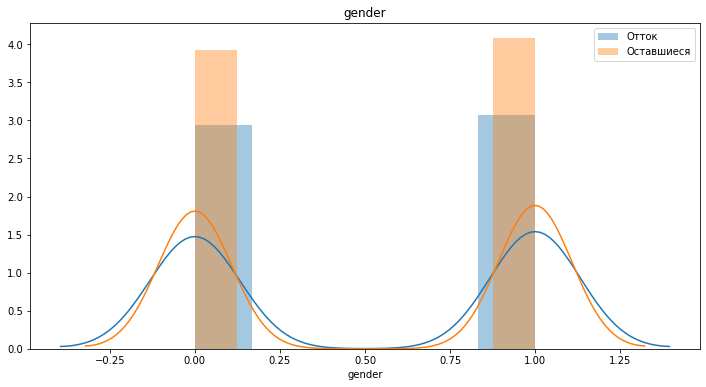

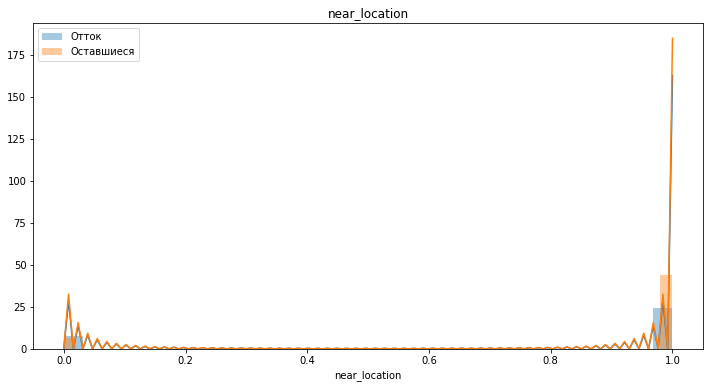

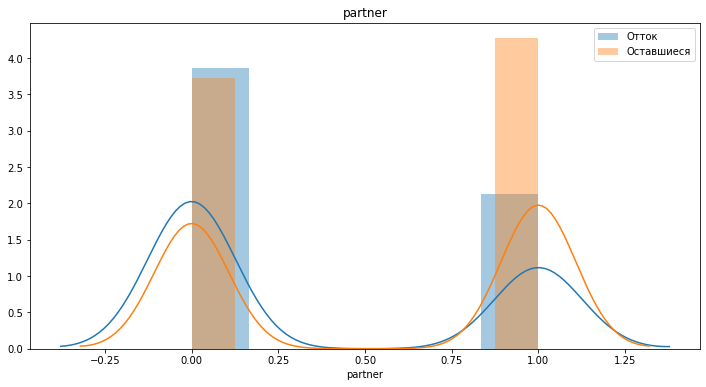

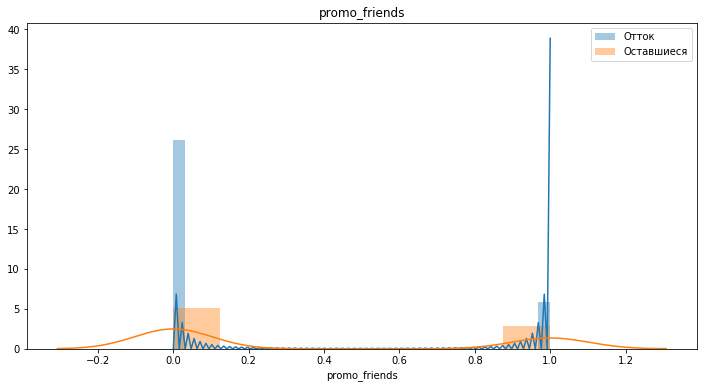

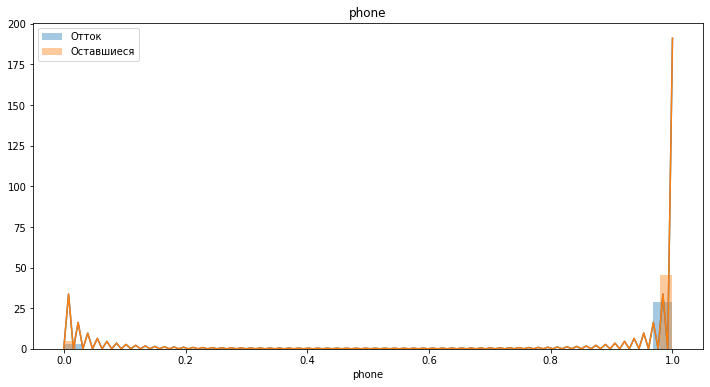

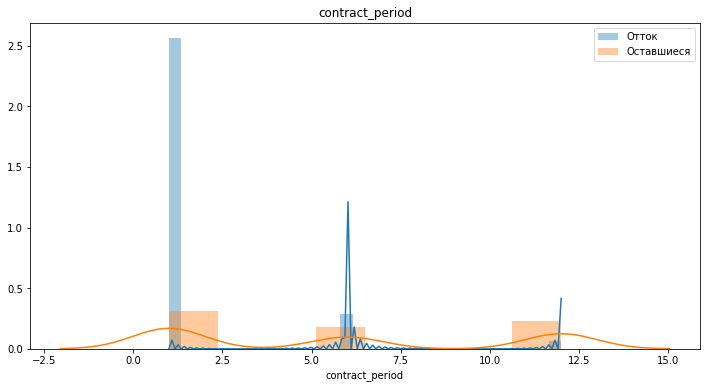

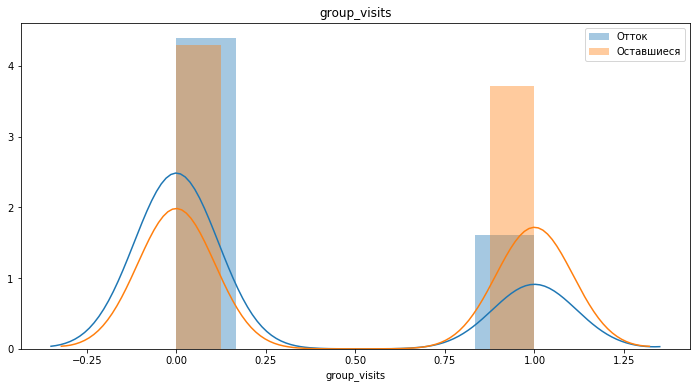

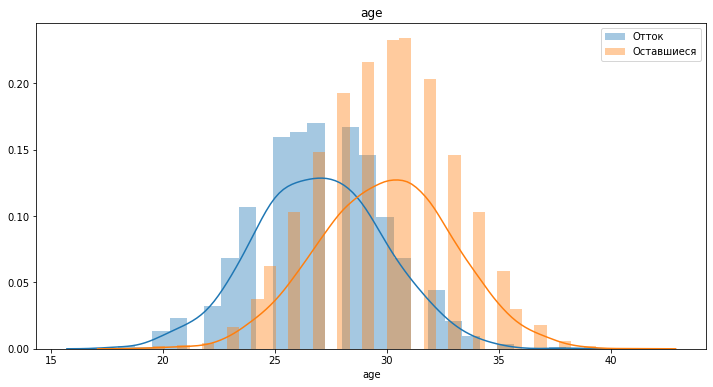

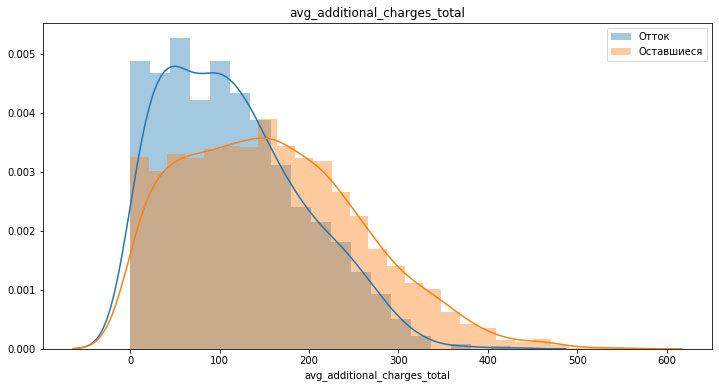

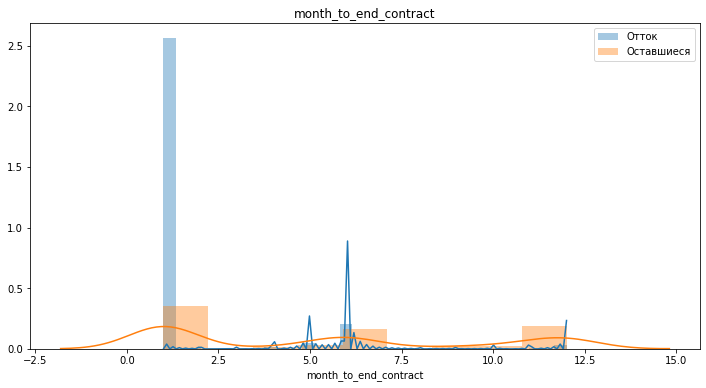

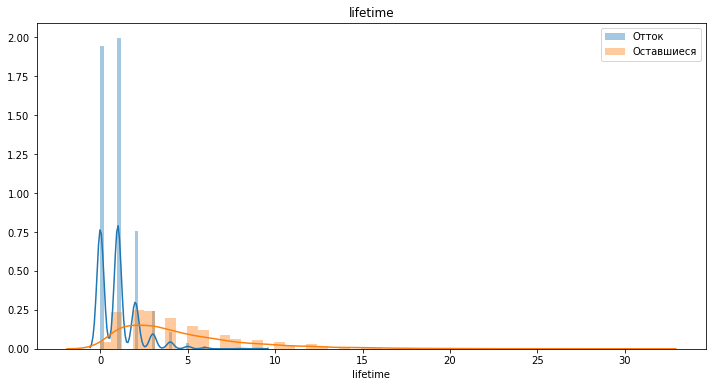

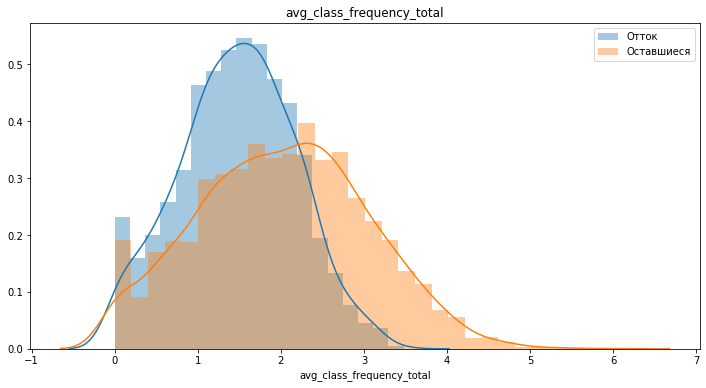

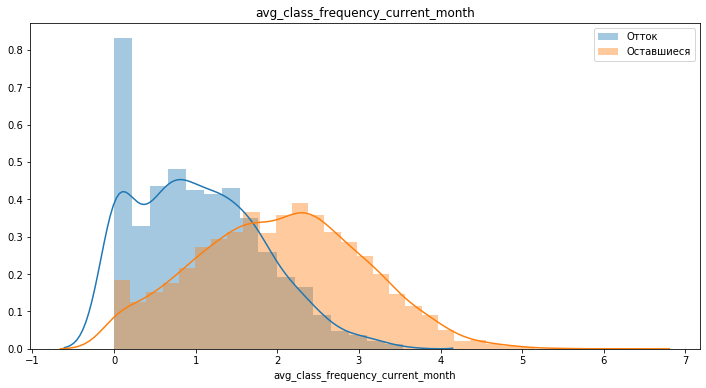

In [8]:
feature = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month']    
                   
for column in feature: 
  plt.figure(figsize=(12,6)) 
  plt.title(column)
  sns.distplot(leave[column])
  sns.distplot(stay[column])
  plt.legend(['Отток', 'Оставшиеся'])
  plt.show()    

Построим матрицу корреляций, отобразим ее на тепловой карте.

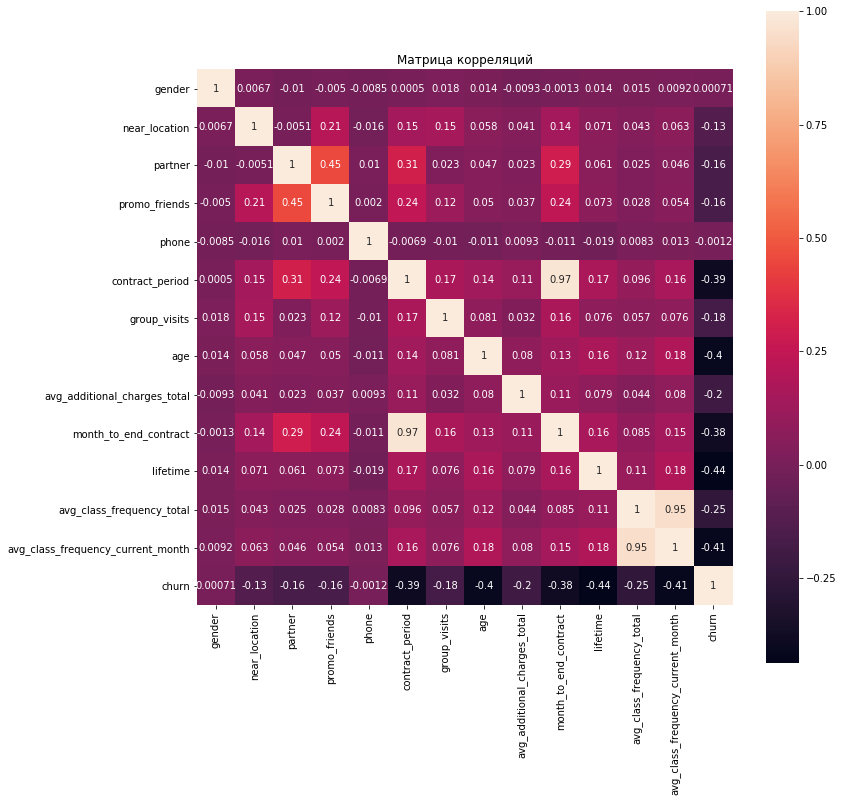

In [9]:
corr_m = data.corr()
plt.figure(figsize=(12,12))
sns.heatmap(corr_m, square=True, annot=True)
plt.title('Матрица корреляций')
plt.show()

Судя по матрице корреляций, нет явной зависимости оттока клиентов от какого-либо из признаков.
При этом есть скоррелированные признаки 'contract_period' и 'month_to_end_contract', а также 'avg_class_frequency_total' и  'avg_class_frequency_current_month'.

#### Вывод 
Провели обработку данных - привели названия колонок к единому регистру, изучили типы данных колонок, они соответствуют ожидаемым и не требуют изменений. Пропущенных значений и дубликатов не обнаружено.

Из полученных данных видно, что в среднем: раcпределение по полу примерно равное; 84,5% пользователей проживает и работает в районе фитнес-центра; 48,7% пользователей являются сотрудниками компаний-партнеров клуба; 30% пришли по программе клуба "Приведи друга"; 90% оставили контактный номер телефона; 4,7 мес - средняя длительность текущего абонемента; 41% пользователей посещают групповые занятия; 29 лет - средний возраст пользователя; 147 - средняя суммарная выручка от дополнительных услуг центра на клиента; 4,3 мес - средний срок до окончания действующего абонемента; 3,7 мес - время с момента первого обращения в фитнес-центр; 1,88 раз - средняя частота посещений в неделю за все время с начала дйствия абонемента; 1,77 раз - средняя частота посещений в неделю по данным за предыдущий месяц; 26,5% - отток пользователей в текущем месяце.

По изменению средних показателей основных признаков для группы с оттоком клиентов и оставшейся группы можно сделать следующие выводы - те, кто живут ближе реже попадает в отток; сотрудники компаний-партнеров реже перестают посещать фитнес-центр, чем другие клиенты; клиенты, пришедшие по акции "Приведи друга" уходят в отток в 2 раза реже; средняя длительность абонемента в оттоке 1,72 месяца - говорит о том, что эти люди чаще берут абонемент на 1-3 месяца; клиенты в группе оттока почти в 2 раза реже посещают групповые занятия, чуть младше в среднем по возрасту, тратят меньше денег на дополнительные услуги центра, время до окончания срока действия договора у таких клиентов логично меньше,а также ниже средняя частота посещения в неделю и за предыдущий месяц. Пол, наличие номера телефона - практически не меняются в обеих группах.

Судя по матрице корреляций, нет явной зависимости оттока клиентов от какого-либо из признаков.
При этом есть скоррелированные признаки 'contract_period' и 'month_to_end_contract', а также 'avg_class_frequency_total' и  'avg_class_frequency_current_month'.



### Шаг 3. Модель прогнозирования оттока клиентов.

Построим модель бинарной классификации клиентов, где целевой признак - факт оттока клиентов в следующем месяце.

Разделение данных на обучающую и валидационную выборки проведем функцией `train_test_split()`. Функция возвращает две матрицы признаков и два вектора с целевой переменной, полученные разделением исходных в пропорции, указанной в `test_size` 80% к 20%. Укажем также параметр `random_state=0`для воспроизводимых случайных значений.

In [10]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'],  axis=1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)


#применим модель логистической регрессии
lr_model = LogisticRegression(solver='liblinear', random_state=0) 
lr_model.fit(X_train_st, y_train)
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

#функция для расчета  метрик
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

print_all_metrics(y_test, lr_predictions, lr_probabilities, title = 'Метрики для модели логистической регрессии:') 

#применим модель случайный лес
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')


Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.97
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.84
	Recall: 0.81
	F1: 0.83
	ROC_AUC: 0.97


#### Вывод 
Доля правильных прогнозов одинакова для обеих моделей, но точность и полнота чуть выше в модели логистической регрессии
Таким образом, модель логистической регрессии показала себя лучше.

### Шаг 4. Кластеризация клиентов.

Стандартизируем данные и построим матрицу расстояний - нарисуем дендрограмму.

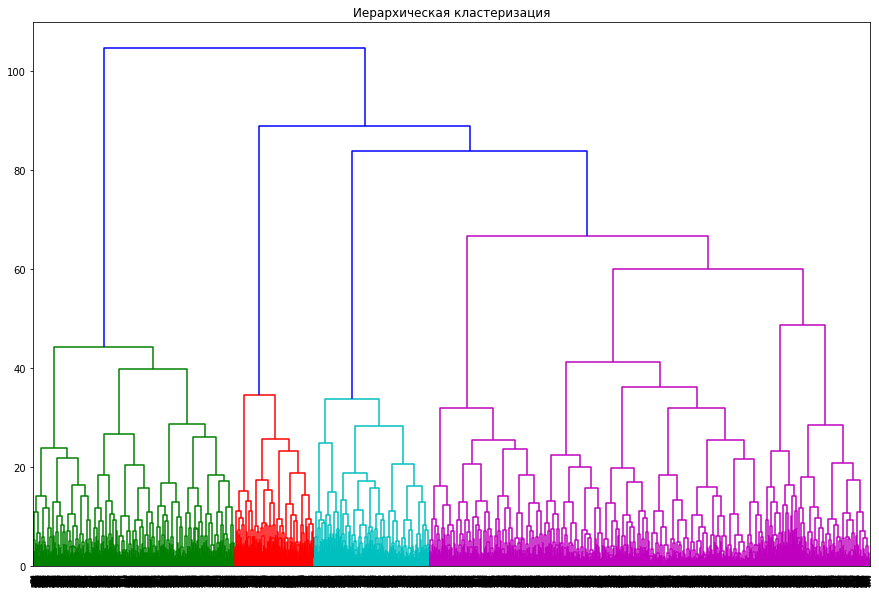

In [12]:
scaler = StandardScaler() 
X_sc = scaler.fit_transform(X) 

linked = linkage(X_sc, method = 'ward') 

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация')
plt.show() 

Судя по дендрограмме, предложенное оптимальное число кластеров равно 4. 

Обучим модель кластеризации на основании алгоритма `K-Means`. Возьмем число кластеров n=5 по задаче проекта.

In [13]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(X_sc)

data['cluster_km'] = labels

Посмотрим на средние значения признаков для кластеров

In [14]:
data.groupby('cluster_km').mean().T

cluster_km,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


5 кластеров клиентов фитнес-центра. 

Кластер 0:
отток - 2,7% - самый низкий;
живут или работают недалеко от фитнес-центра;
преобладают сотрудники компаний-партнеров - 78%;
заключают договора на длительный срок - 12 месяцев;
чаще всех посещают групповые занятия - 54%;
по акции "Приведи друга" пришло больше всех - 57%. Скорей всего постоянные клиенты, сотрудники компаний-партнеров, которые пользуются льготами и привлекают друзей.

Кластер 1:
отток - 44%;
живут или работают далеко от фитнес-центра;
всего 7% из них пришли по акции "Приведи друга";
реже всех посещают групповые занятия - только 21%;
время с момента первого обращения в центр - 2,8 мес;
короткие абонемента 1-3 месяца. Живут или работают достаточно далеко, возможно группа пользователей, ходят больше на индивидуальные тренировки, ходят редко, недавно пришли в клуб.


Кластер 2:
отток - 51% - самый высокий;
живут или работают недалеко;
самые короткие абонементы на 1-3 месяца;
меньше всех тратят деньги на дополнительние услуги клуба;
время с момента первого обращения в центр - 2,4 мес;
наименьшее кол-во посещений за всё время и в последний месяц. Скорей всего, пользователи, которые берут абонементы "на пробу", посмотреть, оценить клуб, мало тратят денег сверх абонемента, недавно пришли в клуб.

Кластер 3:
отток - 26%;
не оставили телефон для связи; 
в среднем 4.5 месяцев абонементы. Большой процент в этой группе от компаний-партнеров.

Кластер 4:
отток - 7%;
живут или работают недалеко от фитнес-центра;
чаще всех посещают клуб - 2.84 раз в неделю;
при этом абонемент на короткий срок - в среднем 2.8 месяцев. Группа постоянных клиентов, часто посещает клуб, тратит много денег на допуслуги, высокий процент групповых занятий.


Построим графики распределения признаков по кластерам.

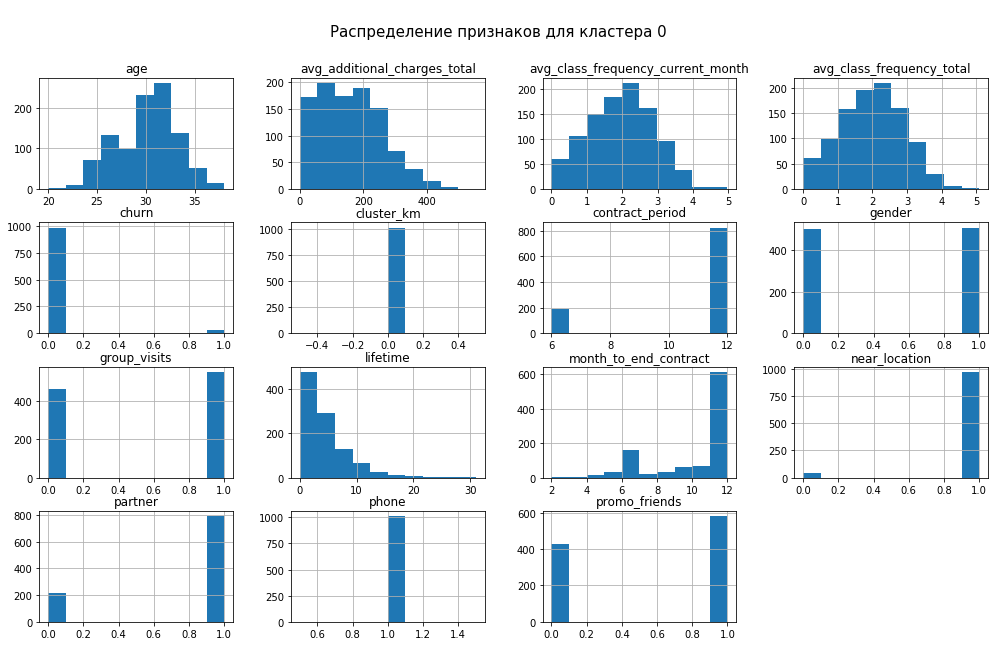

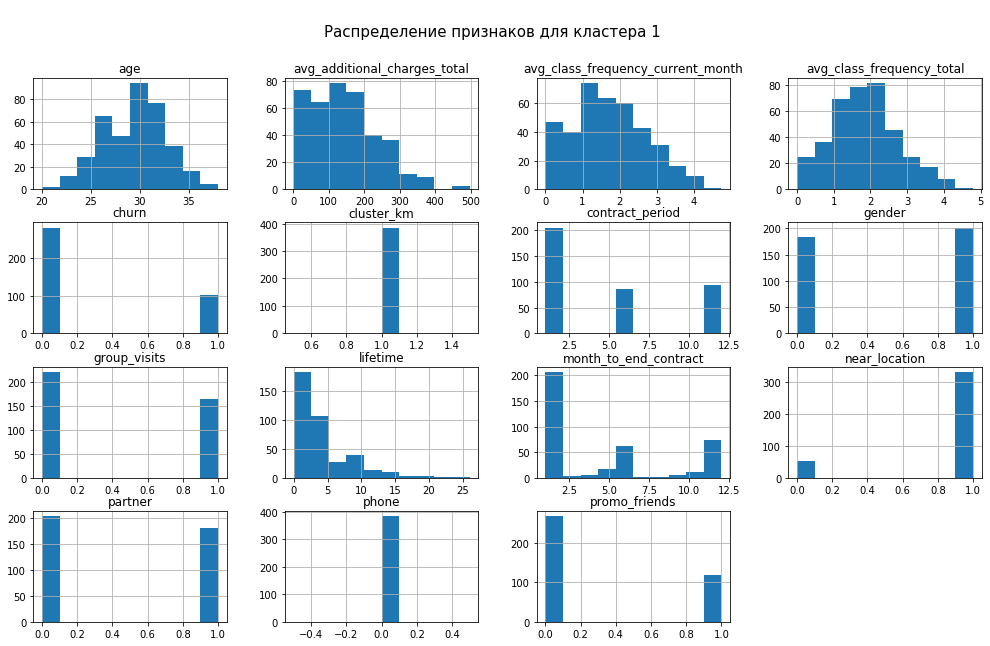

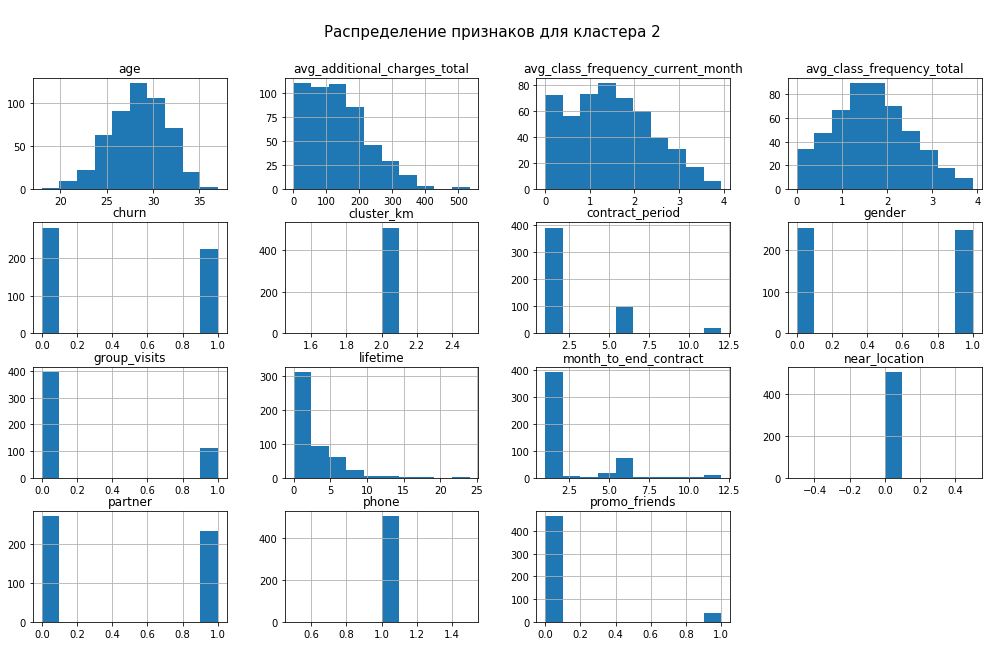

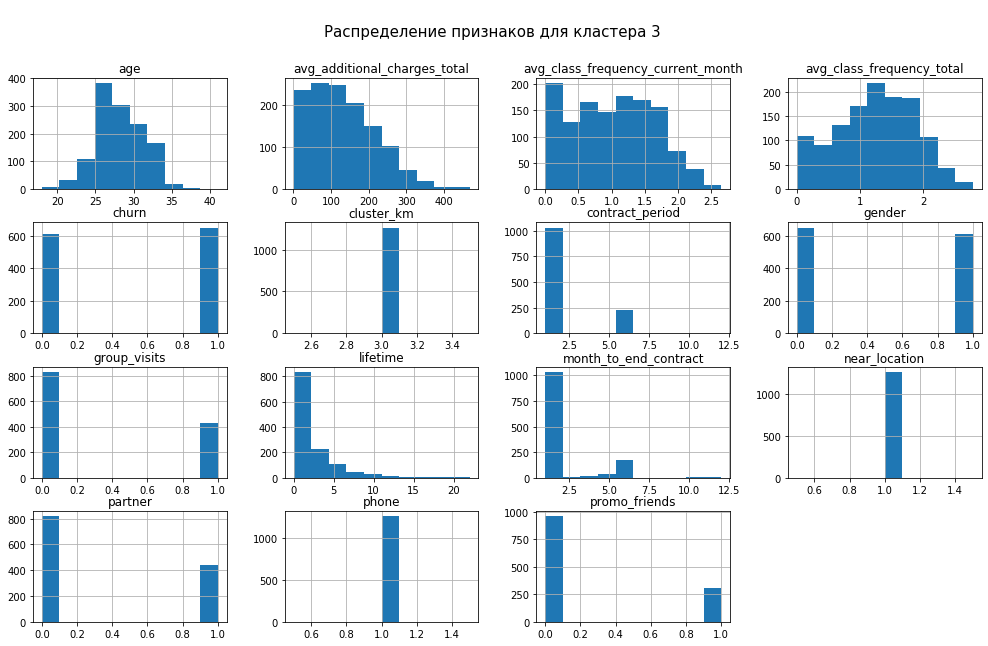

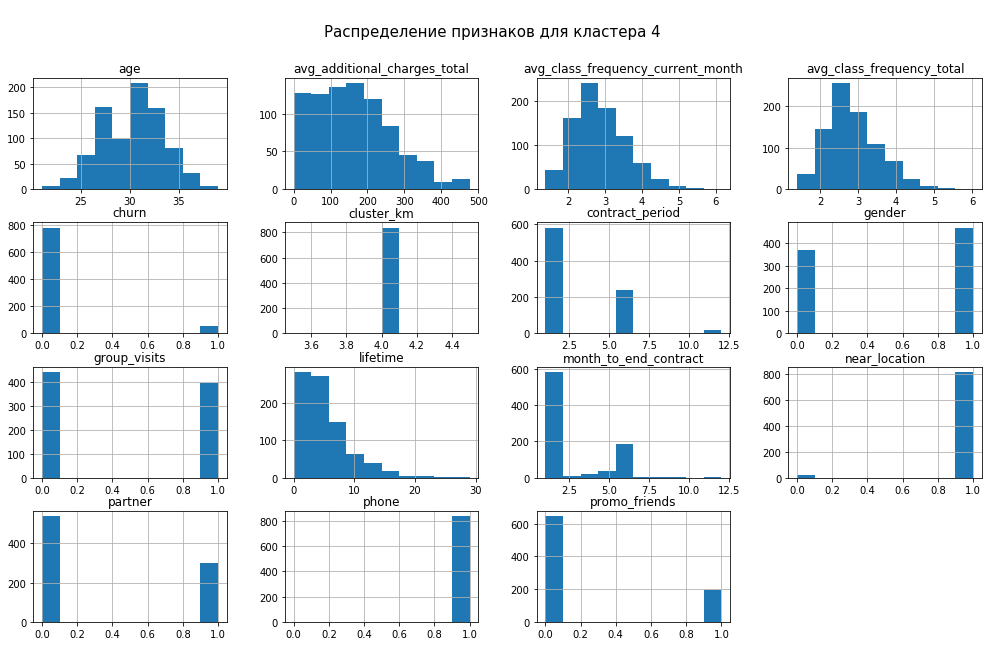

In [16]:
for i in range(5):
     data[data['cluster_km']==i].hist(figsize=(17, 10))
     plt.suptitle('\nРаспределение признаков для кластера {}'.format(i), fontsize = 15)
     plt.show()   

#### Вывод 
Стандартизировали данные, получили 5 кластеров по клиентам. Предположили причины оттока в разных кластерах.

Кластер 0:
отток - 2,7% - самый низкий;
живут или работают недалеко от фитнес-центра;
преобладают сотрудники компаний-партнеров - 78%;
заключают договора на длительный срок - 12 месяцев;
чаще всех посещают групповые занятия - 54%;
по акции "Приведи друга" пришло больше всех - 57%. Скорей всего постоянные клиенты, сотрудники компаний-партнеров, которые пользуются льготами и привлекают друзей.


Кластер 1:
отток - 44%;
живут или работают далеко от фитнес-центра;
всего 7% из них пришли по акции "Приведи друга";
реже всех посещают групповые занятия - только 21%;
время с момента первого обращения в центр - 2,8 мес;
короткие абонемента 1-3 месяца. Живут или работают достаточно далеко, возможно группа пользователей, ходят больше на индивидуальные тренировки, ходят редко, недавно пришли в клуб.


Кластер 2:
отток - 51% - самый высокий;
живут или работают недалеко;
самые короткие абонементы на 1-3 месяца;
меньше всех тратят деньги на дополнительние услуги клуба;
время с момента первого обращения в центр - 2,4 мес;
наименьшее кол-во посещений за всё время и в последний месяц. Скорей всего, пользователи, которые берут абонементы "на пробу", посмотреть, оценить клуб, мало тратят денег сверх абонемента, недавно пришли в клуб.

Кластер 3:
отток - 26%;
не оставили телефон для связи; 
в среднем 4.5 месяцев абонементы. Большой процент в этой группе от компаний-партнеров.

Кластер 4:
отток - 7%;
живут или работают недалеко от фитнес-центра;
чаще всех посещают клуб - 2.84 раз в неделю;
при этом абонемент на короткий срок - в среднем 2.8 месяцев. Группа постоянных клиентов, часто посещает клуб, тратит много денег на допуслуги, высокий процент групповых занятий.

### Шаг 5. Выводы и рекомендации.

Провели обработку данных перед анализом - привели названия колонок к единому регистру, изучили типы данных колонок, они соответствуют ожидаемым и не требуют изменений. Пропущенных значений и дубликатов не обнаружено.

Изучили средние и стандартные отклонения по данным датасета, в среднем: раcпределение по полу примерно равное; 84,5% пользователей проживает и работает в районе фитнес-центра; 48,7% пользователей являются сотрудниками компаний-партнеров клуба; 30% пришли по программе клуба "Приведи друга"; 90% оставили контактный номер телефона; 4,7 мес - средняя длительность текущего абонемента; 41% пользователей посещают групповые занятия; 29 лет - средний возраст пользователя; 147 - средняя суммарная выручка от дополнительных услуг центра на клиента; 4,3 мес - средний срок до окончания действующего абонемента; 3,7 мес - время с момента первого обращения в фитнес-центр; 1,88 раз - средняя частота посещений в неделю за все время с начала дйствия абонемента; 1,77 раз - средняя частота посещений в неделю по данным за предыдущий месяц; 26,5% - отток пользователей в текущем месяце.

По изменению средних показателей основных признаков для группы с оттоком клиентов и оставшейся группы можно сделать следующие выводы - те, кто живут ближе реже попадает в отток; сотрудники компаний-партнеров реже перестают посещать фитнес-центр, чем другие клиенты; клиенты, пришедшие по акции "Приведи друга" уходят в отток в 2 раза реже; средняя длительность абонемента в оттоке 1,72 месяца - говорит о том, что эти люди чаще берут абонемент на 1-3 месяца; клиенты в группе оттока почти в 2 раза реже посещают групповые занятия, чуть младше в среднем по возрасту, тратят меньше денег на дополнительные услуги центра, время до окончания срока действия договора у таких клиентов логично меньше,а также ниже средняя частота посещения в неделю и за предыдущий месяц. Пол, наличие номера телефона - практически не меняются в обеих группах.

Судя по матрице корреляций, нет явной зависимости оттока клиентов от какого-либо из признаков.
При этом есть скоррелированные признаки 'contract_period' и 'month_to_end_contract', а также 'avg_class_frequency_total' и  'avg_class_frequency_current_month'. 

В качестве моделей прогнозирования оттока клиентов использовали логистическую регрессию и модель случайного леса. Доля правильных прогнозов одинакова для обеих моделей, но точность и полнота чуть выше в модели логистической регрессии.
Таким образом, модель логистической регрессии показала себя лучше. По ней возможно прогнозировать вероятность оттока для каждого клиента.

Стандартизировали данные, выделили 5 типичных портретов клиентов, охарактеризовали их основные свойства.

Кластер 0:
отток - 2,7% - самый низкий;
живут или работают недалеко от фитнес-центра;
преобладают сотрудники компаний-партнеров - 78%;
заключают договора на длительный срок - 12 месяцев;
чаще всех посещают групповые занятия - 54%;
по акции "Приведи друга" пришло больше всех - 57%. Скорей всего постоянные клиенты, сотрудники компаний-партнеров, которые пользуются льготами и привлекают друзей.

Кластер 1:
отток - 44%;
живут или работают далеко от фитнес-центра;
всего 7% из них пришли по акции "Приведи друга";
реже всех посещают групповые занятия - только 21%;
время с момента первого обращения в центр - 2,8 мес;
короткие абонемента 1-3 месяца. Живут или работают достаточно далеко, возможно группа пользователей, ходят больше на индивидуальные тренировки, ходят редко, недавно пришли в клуб.


Кластер 2:
отток - 51% - самый высокий;
живут или работают недалеко;
самые короткие абонементы на 1-3 месяца;
меньше всех тратят деньги на дополнительние услуги клуба;
время с момента первого обращения в центр - 2,4 мес;
наименьшее кол-во посещений за всё время и в последний месяц. Скорей всего, пользователи, которые берут абонементы "на пробу", посмотреть, оценить клуб, мало тратят денег сверх абонемента, недавно пришли в клуб.

Кластер 3:
отток - 26%;
не оставили телефон для связи; 
в среднем 4.5 месяцев абонементы. Большой процент в этой группе от компаний-партнеров.

Кластер 4:
отток - 7%;
живут или работают недалеко от фитнес-центра;
чаще всех посещают клуб - 2.84 раз в неделю;
при этом абонемент на короткий срок - в среднем 2.8 месяцев. Группа постоянных клиентов, часто посещает клуб, тратит много денег на допуслуги, высокий процент групповых занятий.

На отток из признаков в большей степени влияют -  посещение групповых занятий, пришел ли человек по акции "Приведи друга", длительность текущего действующего абонемента, использование дополнительных услуг фитнес-центра, время с момента первого обращения в клуб и частота посещения клуба.

Рекомендации - продажа абонементов высокой длительности 6 мес-1 год, особое внимание новым клиентам клуба - это основные группы оттока (удержание за счет информирования о возможности групповых занятий и дополнительных услугах фитнес-центра), маркетинговые акции на привлечение типа "Приведи друга", особенно среди новых  клиентов.